# Computer Vision

Prof. Lee Chilwoo

Student: Dang Xuan Tien - 188163

# Import Libraries

In [36]:
from keras.datasets import fashion_mnist
import numpy as np
import os
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import h5py
import xgboost as xgb
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.feature import hog
import cv2
import pickle
from sklearn.metrics import confusion_matrix

# Overview

- Fashion MNIST dataset includes 10 classes:
    * 0 - T-shirt/top
    * 1 - Trouser
    * 2 - Pullover
    * 3 - Dress
    * 4 - Coat
    * 5 - Sandal
    * 6 - Shirt
    * 7 - Sneaker
    * 8 - Bag
    * 9 - Ankle boot
- Goal: classify 10 classes
- Description dataset:
    * Size of image 28x28
    * Training set: 60,000 images
    * Testing set: 10,000 images
- Feature Extractor: HOG
- Classifiers: SVM and XGBoost
- The link of Fashion MNIST Dataset: https://www.kaggle.com/zalando-research/fashionmnist

# Get Class name

In [5]:
def get_name(indx):
    #indx = np.argmax(ohv)
        
    if indx == 0:
        return 'T-Shirt'
    elif indx == 1:
        return 'Trouser'
    elif indx == 2:
        return 'Pullover'
    elif indx == 3:
        return 'Dress'
    elif indx == 4:
        return 'Coat'
    elif indx == 5:
        return 'Sandal'
    elif indx == 6:
        return 'Shirt'
    elif indx == 7:
        return 'Sneaker'
    elif indx == 8:
        return 'Bag'
    elif indx == 9:
        return 'Ankle boost'

# Load dataset

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [7]:
print("Size of training set: ", np.shape(x_train))
print("Size of training label: ", np.shape(y_train))
print("Size of testing set: ", np.shape(x_test))
print("Size of testing label: ", np.shape(y_test))

Size of training set:  (60000, 28, 28)
Size of training label:  (60000,)
Size of testing set:  (10000, 28, 28)
Size of testing label:  (10000,)


# Show Image in Fashion MNIST dataset

The image of Coat


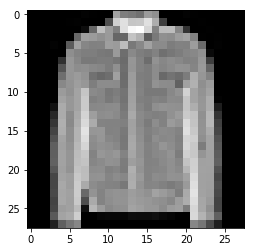

In [10]:
img_indx = np.uint32(np.random.rand()*(y_test.shape[0] - 1))
sample = x_test[img_indx,:,:]

plt.imshow(sample, cmap='gray')
plt.show
print('The image of %s' % (get_name(y_test[img_indx])))

In [47]:
# Extract features using HOG
def creatingDataSet_HOG(data, cell, blk):
  desc = list()

  for i in range(np.shape(data)[0]):
    print(i)
    img = data[i,:,:]
    features, hog_img = hog(img, orientations=9, pixels_per_cell=(cell, cell),
                          cells_per_block=(blk, blk), block_norm='L1', visualise=True)
    features = features.reshape(1, len(features))
    desc.extend(features)
  return desc

# # Extract features using SIFT
# def extractingfeature_SIFT(img, sift):
#   (kps,descs) = sift.detectAndCompute(img,None)
#   return (kps,descs)

# def bowextractingfeature_SIFT(img, sift):
#   kps = sift.detect(img,None)
#   return bow_dictionary.compute(img,kps)

# def creatingDataSet_SIFT(data, sift): 
#   desc = list()
  
#   for i in range(np.shape(data)[0]):
#     print(i)
#     img = data[i,:,:]
#     features = bowextractingfeature_SIFT(img, sift)
#     desc.extend(features)

#   desc = np.array(desc)
#   return desc

# Extract Features

In [ ]:
pf_save = r"G:\STUDY\Sem 1\CV\Project\Features"

# Extract features by HOG
for cell in [7]:
  for blk in [2]:
      print('Extracting train features')
      train_desc = creatingDataSet_HOG(x_train, cell, blk)

      print('Extracting test features')
      test_desc = creatingDataSet_HOG(x_test, cell, blk)

      h5py_fName = ('HOG_C%s_B%s.h5' %(cell, blk))

      with h5py.File(os.path.join(pf_save, h5py_fName), 'w') as hf:
          hf.create_dataset('X_train', data=train_desc, compression="gzip")
          hf.create_dataset('Y_train', data=y_train, compression="gzip")
          hf.create_dataset('X_test', data=test_desc, compression="gzip")
          hf.create_dataset('Y_test', data=y_test, compression="gzip")

# Define functions for training

In [2]:
def model_SVM(train_desc, test_desc, train_labels, test_labels, txt_file, path, cell, blk):
    
    for ker in ['rbf']:
        for C in [0.01,1, 10]:
            for gamma in [0.1, 1, 10]:
                print(ker, C, gamma)
                classif = OneVsRestClassifier(SVC(kernel=ker, C = C, gamma = gamma))
                classif.fit(train_desc, train_labels)

                filename = (r'%s\C%s_B%s_SVM_%s_C%s_gamma%s.pkl' %(path,cell, blk, ker, C, gamma))
                pickle.dump(classif, open(filename, 'wb'))


                train_pre = classif.predict(train_desc)
                train_confusion = confusion_matrix(train_labels, train_pre)
                train_acc = float(np.sum(np.diagonal(train_confusion)))/np.sum(np.sum(train_confusion))

                test_pre = classif.predict(test_desc)
                test_confusion = confusion_matrix(test_labels, test_pre)
                test_acc = float(np.sum(np.diagonal(test_confusion))) / np.sum(np.sum(test_confusion))


                print('%s, %s\n' %(train_acc, test_acc))
                txt_file.write('Kernel: %s,C = %s, gamma = %s, train = %s, test = %s\n' %(ker, C, gamma, 
                                                                                          train_acc, test_acc))
                
def model_xgboost(train_desc, test_desc, train_labels, test_labels, txt_file, path, cell, blk):
    
    # Transfer orginal data to DMatrix (A type of XGBoost)
    dtrain = xgb.DMatrix(train_desc, label=train_labels)
    dtest = xgb.DMatrix(test_desc, label=test_labels)
    
    num_round = 10
    
    for maxD in [6, 12]:
        for eta in [0.1, 0.5]:
            print(maxD, eta)
            # Set parameters for training based on XGBoost
            param = {'max_depth':maxD, 'eta':eta, 'objective':'multi:softmax', 
                     'num_class': 10}
            
            # Declare model and training
            classif = xgb.train(param, dtrain, num_round)
            
            # Save model
            filename = (r'%s\C%s_B%s_XGBoost_MxD%s_lr%s.pkl' %(path, cell, blk, maxD, eta))
            pickle.dump(classif, open(filename, 'wb'))
            
            # Predict model on training set
            train_pre = classif.predict(dtrain)
            train_confusion = confusion_matrix(train_labels, train_pre)
            train_acc = float(np.sum(np.diagonal(train_confusion)))/np.sum(np.sum(train_confusion))

            # Predict model on testing set
            test_pre = classif.predict(dtest)
            test_confusion = confusion_matrix(test_labels, test_pre)
            test_acc = float(np.sum(np.diagonal(test_confusion))) / np.sum(np.sum(test_confusion))

            # Write the results on file
            print('%s, %s\n' %(train_acc, test_acc))
            txt_file.write("lr = %s, maxD = %s" %(eta, maxD))
            txt_file.write("train = %s, test = %s\n" %(train_acc, test_acc))

# Running

In [11]:
# Some path
pf_save = r'G:\STUDY\Sem 1\CV\Project\model'
pf_result = r'G:\STUDY\Sem 1\CV\Project\results'
pf_feature = r'G:\STUDY\Sem 1\CV\Project\Features'

# Declare txt file names
txtName2 = ('%s\\result_HOG_XGBoost.txt' %pf_result)
txt_file2 = open(txtName2, "w")

for cell in [4, 7]:
    for blk in [2, 4]:
        #Read data HOG
        h5py_fName = ('HOG_C%s_B%s.h5' %(cell, blk))
        h5f = h5py.File(os.path.join(pf_feature, h5py_fName), 'r')

        X_train_HOG = h5f['X_train'][:]
        Y_train_HOG = h5f['Y_train'][:]

        X_test_HOG = h5f['X_test'][:]
        Y_test_HOG = h5f['Y_test'][:]
        
        print("size of training features: ", np.shape(X_train_HOG))
        print("size of testing features: ", np.shape(X_test_HOG))

        txt_file2.write('HOG: Cell = %s, blk = %s\n' %(cell, blk))
        
        # Training
        model_xgboost(X_train_HOG, X_test_HOG, Y_train_HOG, Y_test_HOG, txt_file2, pf_save, cell, blk)

txt_file2.close()

size of training features:  (60000, 1296)
size of testing features:  (10000, 1296)
6 0.1
0.8893333333333333, 0.848

6 0.5
0.9328, 0.8648

12 0.1
0.9847833333333333, 0.8649

12 0.5
0.9998166666666667, 0.8674

size of training features:  (60000, 2304)
size of testing features:  (10000, 2304)
6 0.1
0.8883666666666666, 0.846

6 0.5
0.93105, 0.865

12 0.1
0.9829166666666667, 0.8652

12 0.5
0.9998166666666667, 0.8662

size of training features:  (60000, 324)
size of testing features:  (10000, 324)
6 0.1
0.85615, 0.8135

6 0.5
0.9034333333333333, 0.8333

12 0.1
0.9770833333333333, 0.8383

12 0.5
0.9988833333333333, 0.8425

size of training features:  (60000, 144)
size of testing features:  (10000, 144)
6 0.1
0.84805, 0.8095

6 0.5
0.8962166666666667, 0.8318

12 0.1
0.9738166666666667, 0.8384

12 0.5
0.9985, 0.8399



# Example

In [37]:
pf_save = r'G:\STUDY\Sem 1\CV\Project\model'
pf_result = r'G:\STUDY\Sem 1\CV\Project\results'
pf_feature = r'G:\STUDY\Sem 1\CV\Project\Features'

txtName2 = ('%s\\result_HOG_XGBoost.txt' %pf_result)
txt_file2 = open(txtName2, "w")

cell = 2
blk = 2
#Read data HOG
h5py_fName = ('HOG_C%s_B%s.h5' %(cell, blk))
h5f = h5py.File(os.path.join(pf_feature, h5py_fName), 'r')

X_train_HOG = h5f['X_train'][:]
Y_train_HOG = h5f['Y_train'][:]
X_test_HOG = h5f['X_test'][:]
Y_test_HOG = h5f['Y_test'][:]

print("size of training features: ", np.shape(X_train_HOG))
print("size of testing features: ", np.shape(X_test_HOG))

#Training
dtrain = xgb.DMatrix(X_train_HOG, label=Y_train_HOG)
dtest = xgb.DMatrix(X_test_HOG, label=Y_test_HOG)

param = {'max_depth':12, 'eta':0.5, 'objective':'multi:softmax', 
                     'num_class': 10}

classif = xgb.train(param, dtrain, 10)
test_pre = classif.predict(dtest)

print(confusion_matrix(Y_test_HOG, test_pre))


size of training features:  (60000, 6084)
size of testing features:  (10000, 6084)
[[818   4  20  28  10   1 108   0  11   0]
 [  2 950   3  24   6   0  13   0   2   0]
 [ 19   0 789  14 100   0  73   0   5   0]
 [ 20  11   8 878  34   1  44   0   2   2]
 [  1   2  89  47 783   0  71   0   7   0]
 [  0   0   0   0   0 939   0  40   4  17]
 [152   2  77  36 104   0 608   0  21   0]
 [  0   0   0   0   0  21   0 943   1  35]
 [  3   1   3   5  10   6   7   2 962   1]
 [  1   0   0   1   0  11   1  37   0 949]]


In [50]:
test_acc = float(np.sum(np.diagonal(confusion_matrix(Y_test_HOG, test_pre)))) / np.sum(np.sum(confusion_matrix(Y_test_HOG, test_pre)))
print("Accuracy %s percent" %(test_acc*100))

Accuracy 86.19 percent


>True label Shirt
>Predict label Shirt


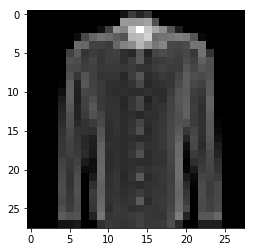

In [52]:
img_indx = np.uint32(np.random.rand()*(y_test.shape[0] - 1))
sample = x_test[img_indx,:,:]

plt.imshow(sample, cmap='gray')
plt.show
print('>True label %s' % (get_name(y_test[img_indx])))
print('>Predict label %s' % (get_name(test_pre[img_indx])))